In [1]:
from wealth_process_V_opt import *
from optim import *
from decimal import *
import pandas as pd
import warnings
import time
import seaborn as sns

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Mean Variance trade-off

The wealth of a miner is provided by 

$$
X_t = x - c\cdot t + b\cdot N_t, \quad t\geq0,  
$$

when solo mining. 

The mean and variance, over some time horizon $T$ are given by 

$$
\mathbb{E}(X_T) = x - cT +b\lambda T\text{, and } \mathbb{V}(X_T) = b^2\lambda T
$$





In [2]:
lam ,b = 6, 3.125 # block discovery rate of the network and reward for finding a block
# Rate of discovery by the network is 6 blocks per hour and the block finding reward is 3.125
c = lam * b / 1.3  # operational cost per time unit (profitability on average)
print(c)
x = 0  # initial wealth of the miner
X_solo = wealth_process(lam, b, c, 0, 1) # Define the wealth process for a solo miner
# Compute the expected value of the wealth process at time T=1
X_solo.E(x), X_solo.Var()

14.423076923076923


(4.326923076923077, 58.59375)

The miner can mitigate the risk by mining for a pool instead of mining solo. Say, there are $n$ mining pools offering a rate of share discoveries $\lambda_k$ and a reward $b_k$ for $k = 1,\ldots, n$, such that 

$$\lambda_0 < \lambda_1 <\ldots < \lambda_n\text{ and }b_0>b_1>\ldots >b_n,$$

where $\lambda_0$ and $b_0$ correspond to the characteristics of solo mining. We can caracterize the reward and arrival rate of the pools by defining a pool fee $f_k$ and difficulty reduction $\delta_k$ for $k = 1,\ldots, n$. 

## Example 3

In [3]:
f0, f1, f2, f3 =0, 0.005, 0.01, 0.1  # pool fees
delta0, delta1, delta2, delta3 = 1, 0.99, 0.85, 0.75  # difficulty reduction
deltas = np.array([delta0, delta1, delta2, delta3])
fs = np.array([f0, f1, f2, f3])  # pool fees
lams= lam / deltas # arrival rates of the pools
bs = b * (1 - fs) * deltas  # rewards after pool fees
X_pools = [wealth_process(lam, b, c, 0, 1 ) for lam, b in zip(lams, bs)]
# Compute the expected values and variance of the wealth process at time T=1 for each pool
E_pools = [X.E(x) for X in X_pools]
Var_pools = [X.Var() for X in X_pools]
E_pools, Var_pools
lams, bs

(array([6.        , 6.06060606, 7.05882353, 8.        ]),
 array([3.125     , 3.07828125, 2.6296875 , 2.109375  ]))

The miner can split her resources  accross the pools, the wealth process then is given by 

$$
X_t = x -c\cdot t + \sum_{i = 1}^{N_t}B_i,
$$

which allows the miner to adjust her mean and variance trade-off. The split is characterized by a weight vector $w = \left(\begin{array}{ccc}w_0 &\cdots& w_{n}\end{array}\right)$.

In [4]:
np.random.seed(42) # Fix the random seed for reproducibility
n = 4 # specify the number of pools
alpha = np.ones(n)  # parameter of the Dirichlet distribution
w = np.random.dirichlet(alpha)
print(f"Weight vector w = {w}")
X_mixed = wealth_process(lams, bs, c, n, w)
X_mixed.E(x), X_mixed.Var()

Weight vector w = [0.08219683 0.52725178 0.2306407  0.15991069]


(3.934415551015171, 52.046390713056894)

The goal is now to find the computing power distribution that achieve a good mean variance trade-off!

## Risk aversion parameter and mean-variance trade off

Assume that the miner is characterized by a risk aversion parameter $\gamma$ and wishes to optimize the following criteria

$$
V(w) = \mathbb{E}(X_T) - \gamma \mathbb{V}(X_T).
$$

Mean variance trade-off with risk aversion $\gamma_l$ leads to choose one pool,

$$
k^\ast = \underset{k = 0,\ldots, n}\argmax \,\lambda_k(b_k - \gamma\cdot b_k^2),\text{ }l=1, \ldots, m.
$$

which depends on the risk aversion parameter. The choice can be visualized by plotting $\gamma \mapsto \lambda_k(b_k - \gamma\cdot b_k^2)$ for ecah $k = 1,\ldots, n$

## Figure 3

        solo      Pool1      Pool2      Pool3  gamma
0  18.164062  18.081958  18.074364  16.519043   0.01
1  17.578125  17.507666  17.586229  16.163086   0.02
2  16.992188  16.933374  17.098093  15.807129   0.03
3  16.406250  16.359083  16.609957  15.451172   0.04
4  15.820312  15.784791  16.121821  15.095215   0.05


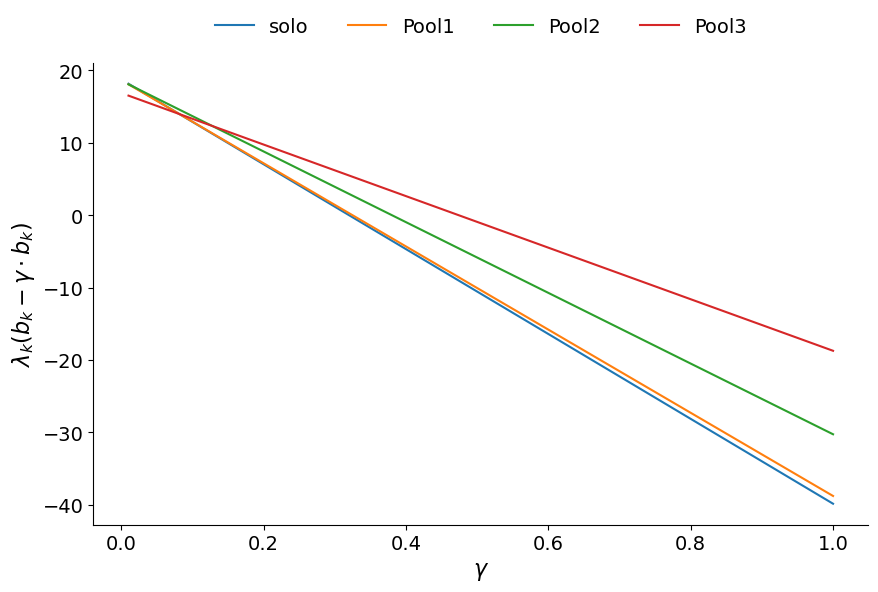

In [5]:
gams = np.linspace(0.01, 1, 100)
columns = ['solo'] + [f'Pool{k}' for k in range(1, len(bs))]
df = pd.DataFrame([lams * (bs - gam * (bs)**2) for gam in gams], columns=columns)
df['gamma'] = gams
print(df.head())
df.plot(x='gamma', y=columns, kind='line', title='', figsize=(10, 6))

plt.xlabel(r'$\gamma$')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$\gamma$', fontsize=16)
plt.ylabel(r'$\lambda_k(b_k - \gamma\cdot b_k)$', fontsize=16)

plt.legend(
    title='',
    fontsize=14,
    title_fontsize=16,
    loc='lower center',
    bbox_to_anchor=(0.5, 1.02),
    ncol=4,
    frameon=False
)
# 
# plt.legend(title='', fontsize=14, title_fontsize=16, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)

sns.despine()
plt.savefig('../figures/risk_aversion_mean_variance_tradeoff.pdf', format='pdf')
plt.show()


## Mean-Variance Efficient frontier

The mean-variance trade-off can follow from maximizing expected wealth 
$$
\sum_{k = 0}^n w_k \lambda^l_k b_k
$$
under variance constraints

$$
\sum_{k = 0}^n w_k \lambda^l_k b_k^2 = \sigma^2
$$

We have it explicitly for $n = 2$. Indeed,

$$
w_2 = 1 - w_1 - w_0\text{ } w_1 = \frac{\sigma^2 - \lambda_2 b_2^2 - w_0(\lambda_0 b_0^2 - \lambda_2 b_2^2)}{\lambda_1 b_{1}^2-\lambda_2 b_{2}^2}\text{, and }w_0 = \frac{\sigma^2 - \lambda_2 b_2^2}{\lambda_0 b_0^2 - \lambda_2 b_2^2}
$$

## Example 4

In [6]:
import pandas as pd
from itertools import permutations


# lam_l, c_l, x_l = lam_m[l], c_m[l], x_m[l]
# d_n, f_n = np.array([1, 0.9,0.6, 0.5, 0.1]), np.array([0, 0.01,0.3, 0.31, 0.5])

print(n)
# Generate weights for each pool
ws = np.arange(0.01, 1, 0.01)
if n >= 1:
    # Generate all possible combinations of weights for n+1 pools
    w_all_in_one_pool = []
    for perm in permutations(range(n), 2):
        for w in ws:
            weights = np.zeros(n)
            weights[perm[0]] = w
            weights[perm[1]] = 1 - w
            w_all_in_one_pool.append(weights)
    w_all_in_one_pool = np.array(w_all_in_one_pool)

    # Add a couple of Dirichlet distributed vectors with parameters all equal to one
    # dirichlet_vectors = np.random.dirichlet(np.ones(n + 1), size=100)
    # w_all_in_one_pool = np.vstack([w_all_in_one_pool, dirichlet_vectors])
w_all_in_one_pool


X0 = [wealth_process(lams, bs, c, n, w) for w in w_all_in_one_pool]

# # # # Create a DataFrame with the required columns
E_var_df = pd.DataFrame(
    [[X.E(0), X.Var()] + list(w) for X, w in zip(X0, w_all_in_one_pool)],
    columns=['E', 'Var'] + [f'w{i}' for i in range(n)]
)
E_var_df['pools'] = E_var_df[[f'w{i}' for i in range(n)]].apply(
    lambda row: ''.join([str(i) for i, w in enumerate(row) if w > 0]),
    axis=1
)
E_var_df


4


,E,Var,w0,w1,w2,w3,pools
0,4.234111,57.440830,0.01,0.99,0.00,0.00,01
1,4.235048,57.452476,0.02,0.98,0.00,0.00,01
2,4.235986,57.464122,0.03,0.97,0.00,0.00,01
3,4.236923,57.475767,0.04,0.96,0.00,0.00,01
4,4.237861,57.487413,0.05,0.95,0.00,0.00,01
...,...,...,...,...,...,...,...
1183,2.536298,36.256597,0.00,0.00,0.05,0.95,23
1184,2.519423,36.124418,0.00,0.00,0.04,0.96,23
1185,2.502548,35.992239,0.00,0.00,0.03,0.97,23
1186,2.485673,35.860061,0.00,0.00,0.02,0.98,23


The efficient frontier is formed by combination of two pools 

## Figure 4

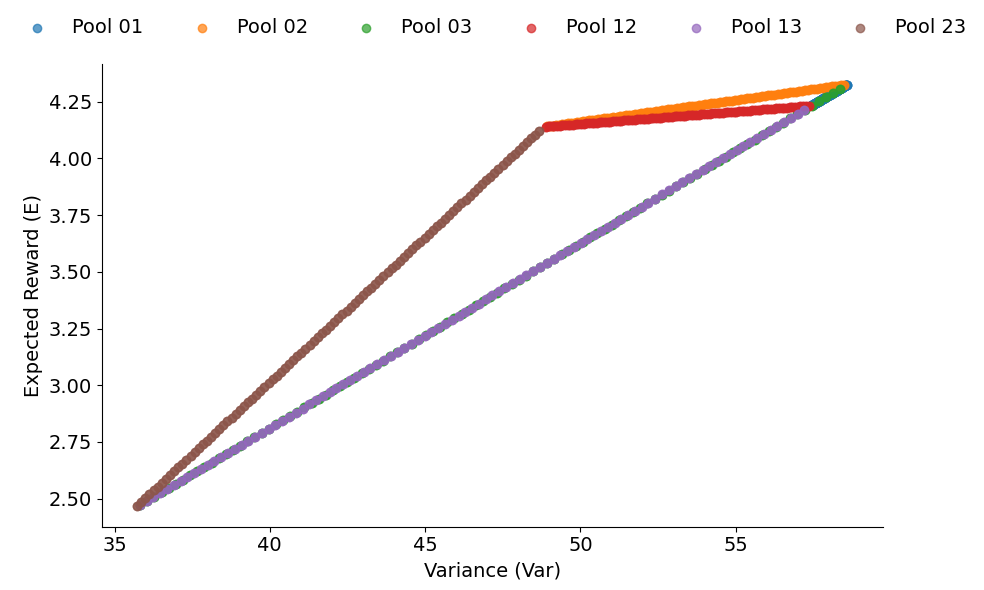

In [7]:
import matplotlib.pyplot as plt
plt.rcParams.update({'pdf.fonttype': 42, 'ps.fonttype': 42})  # Ensure text is embedded in the PDF
# Scatter plot
plt.figure(figsize=(10, 6))
for pool in E_var_df['pools'].unique():
    subset = E_var_df[E_var_df['pools'] == pool]
    plt.scatter(subset['Var'], subset['E'], label=f'Pool {pool}', alpha=0.7)
    # Add a vertical line to indicate the value of sig_2
# plt.axvline(x=sig_2, color='red', linestyle='--', label=f'sig_2 = {sig_2:.2f}')
# Labels and legend
plt.xlabel('Variance (Var)', fontsize=14)
plt.ylabel('Expected Reward (E)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(
    title='',
    fontsize=14,
    title_fontsize=16,
    loc='lower center',
    bbox_to_anchor=(0.5, 1.02),
    ncol=6,
    frameon=False
)# Ensure legend is properly configured
plt.tight_layout()  # Adjust layout to prevent clipping
sns.despine()
# Save the plot as a PDF file in the Figures folder
plt.savefig('../figures/efficient_frontier.pdf', format='pdf')

plt.show()  # Ensure plt.show() is called after all customizations
